# Replication Notebook for JSS paper
### Estimated total running time: 10 minutes (Apple MacBook Pro M1 32Gb RAM)

# Data Preparation

For simplicity of presentation, we considered $M=2$ competing events, though PyDTS can handle any number of competing events as long as there are enough observed failures of each failure type, at each discrete time point.

Here, $d=30$ discrete time points, $n=50,000$ observations, and $Z$ with 5 covariates. Failure times of observations were generated based on the model:

$$
\lambda_{j}(t|Z) = \frac{\exp(\alpha_{jt}+Z^{T}\beta_{j})}{1+\exp(\alpha_{jt}+Z^{T}\beta_{j})}
$$

with 

$\alpha_{1t} = -1 -0.3 \log(t)$, 

$\alpha_{2t} = -1.75 -0.15\log(t)$, $t=1,\ldots,d$,

$\beta_1 = (-\log 0.8, \log 3, \log 3, \log 2.5, \log 2)$, 

$\beta_{2} = (-\log 1, \log 3, \log 4, \log 3, \log 2)$. 

Censoring time for each observation was sampled from a discrete uniform distribution, i.e. $C_i \sim \mbox{Uniform}\{1,...,d+1\}$.

Our goal is estimating $\{\alpha_{11},\ldots,\alpha_{1d},\beta_1^T,\alpha_{21},\ldots,\alpha_{2d},\beta_2^T\}$ (70 parameters in total) along with the standard error of the estimators.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pydts.examples_utils.generate_simulations_data import generate_quick_start_df
import warnings
pd.set_option("display.max_rows", 500)
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
real_coef_dict = {
    "alpha": {
        1: lambda t: -1 - 0.3 * np.log(t),
        2: lambda t: -1.75 - 0.15 * np.log(t)
    },
    "beta": {
        1: -np.log([0.8, 3, 3, 2.5, 2]),
        2: -np.log([1, 3, 4, 3, 2])
    }
}

n_patients = 50000
n_cov = 5

In [3]:
patients_df = generate_quick_start_df(n_patients=n_patients, n_cov=n_cov, d_times=30, j_events=2, 
                                      pid_col='pid', seed=0, censoring_prob=0.8, 
                                      real_coef_dict=real_coef_dict)

patients_df.head()

,pid,Z1,Z2,Z3,Z4,Z5,J,T,C,X
0,0,0.548814,0.715189,0.602763,0.544883,0.423655,0,30,10,10
1,1,0.645894,0.437587,0.891773,0.963663,0.383442,0,30,24,24
2,2,0.791725,0.528895,0.568045,0.925597,0.071036,0,17,11,11
3,3,0.087129,0.020218,0.832620,0.778157,0.870012,1,1,30,1
4,4,0.978618,0.799159,0.461479,0.780529,0.118274,0,15,14,14


## Checking the Data

Both estimation methods require enough observed failures of each failure type, at each discrete time point. Therefore, the first step is to make sure this is in fact the case with the data at hand.

As shown below, in our example, the data comply with this requirement. 

Preprocessing suggestions for cases when the data do not comply with this requirement are shown in Data Regrouping Example.

<AxesSubplot:xlabel='Time', ylabel='Number of Observations'>

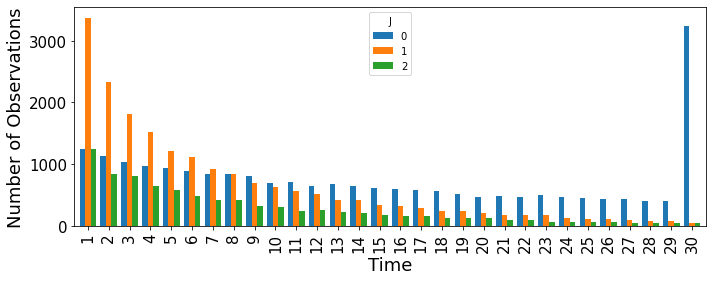

In [4]:
from pydts.examples_utils.plots import plot_events_occurrence
plot_events_occurrence(patients_df)

In [5]:
patients_df.groupby(['J', 'X'])['pid'].count().unstack('J')

J,0,1,2
X,,,
1,1236,3374,1250
2,1124,2328,839
3,1029,1805,805
4,972,1524,644
5,939,1214,570
6,889,1114,483
7,830,916,416
8,832,830,409
9,797,683,323


# Estimating with DataExpansionFitter

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pydts.examples_utils.generate_simulations_data import generate_quick_start_df
import warnings
pd.set_option("display.max_rows", 500)
warnings.filterwarnings('ignore')
%matplotlib inline

In [7]:
real_coef_dict = {
    "alpha": {
        1: lambda t: -1 - 0.3 * np.log(t),
        2: lambda t: -1.75 - 0.15 * np.log(t)
    },
    "beta": {
        1: -np.log([0.8, 3, 3, 2.5, 2]),
        2: -np.log([1, 3, 4, 3, 2])
    }
}

n_patients = 50000
n_cov = 5

In [8]:
patients_df = generate_quick_start_df(n_patients=n_patients, n_cov=n_cov, d_times=30, j_events=2, 
                                      pid_col='pid', seed=0, censoring_prob=0.8, 
                                      real_coef_dict=real_coef_dict)
patients_df.head()

,pid,Z1,Z2,Z3,Z4,Z5,J,T,C,X
0,0,0.548814,0.715189,0.602763,0.544883,0.423655,0,30,10,10
1,1,0.645894,0.437587,0.891773,0.963663,0.383442,0,30,24,24
2,2,0.791725,0.528895,0.568045,0.925597,0.071036,0,17,11,11
3,3,0.087129,0.020218,0.832620,0.778157,0.870012,1,1,30,1
4,4,0.978618,0.799159,0.461479,0.780529,0.118274,0,15,14,14


## Estimation

In the following we apply the estimation method of Lee et al. (2018). Note that the data dataframe must not contain a column named 'C'.

In [9]:
from pydts.fitters import DataExpansionFitter
fitter = DataExpansionFitter()
fitter.fit(df=patients_df.drop(['C', 'T'], axis=1))

fitter.print_summary()



Model summary for event: 1
                 Generalized Linear Model Regression Results                  
Dep. Variable:                    j_1   No. Observations:               536780
Model:                            GLM   Df Residuals:                   536745
Model Family:                Binomial   Df Model:                           34
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -78272.
Date:                Tue, 02 Aug 2022   Deviance:                   1.5654e+05
Time:                        16:44:35   Pearson chi2:                 5.35e+05
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01509
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
C(X)[1]       -0.9459  

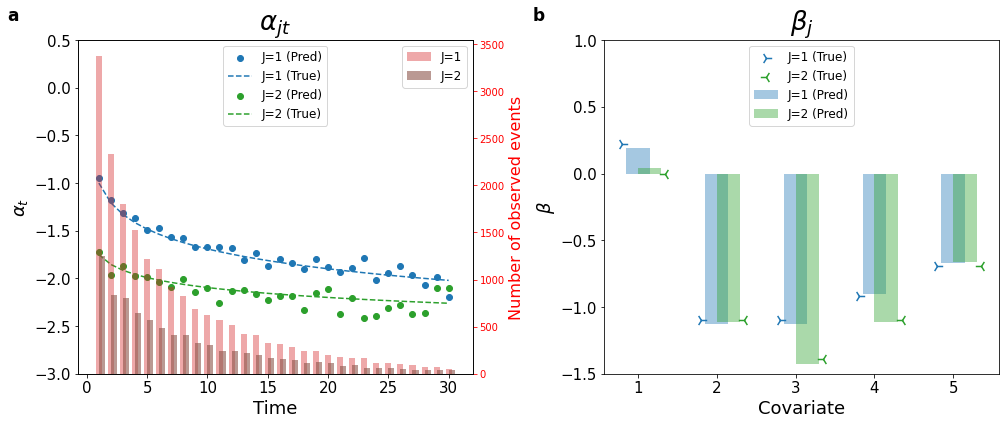

In [10]:
from pydts.examples_utils.plots import plot_first_model_coefs
plot_first_model_coefs(models=fitter.event_models, times=fitter.times, train_df=patients_df, n_cov=5)

In [11]:
summary = fitter.event_models[1].summary()
summary_df = pd.DataFrame([x.split(',') for x in summary.tables[1].as_csv().split('\n')])
summary_df.columns = summary_df.iloc[0]
summary_df = summary_df.iloc[1:].set_index(summary_df.columns[0])
lee_beta1_summary = summary_df.iloc[-5:]
lee_beta1_summary

,coef,std err,z,P>|z|,[0.025,0.975]
,,,,,,
Z1,0.1930,0.026,7.495,0.000,0.143,0.244
Z2,-1.1306,0.026,-42.971,0.000,-1.182,-1.079
Z3,-1.1237,0.026,-42.515,0.000,-1.176,-1.072
Z4,-0.8986,0.026,-34.377,0.000,-0.950,-0.847
Z5,-0.6720,0.026,-25.869,0.000,-0.723,-0.621


In [12]:
summary = fitter.event_models[2].summary()
summary_df = pd.DataFrame([x.split(',') for x in summary.tables[1].as_csv().split('\n')])
summary_df.columns = summary_df.iloc[0]
summary_df = summary_df.iloc[1:].set_index(summary_df.columns[0])
lee_beta2_summary = summary_df.iloc[-5:]
lee_beta2_summary

,coef,std err,z,P>|z|,[0.025,0.975]
,,,,,,
Z1,0.0411,0.038,1.074,0.283,-0.034,0.116
Z2,-1.1128,0.039,-28.419,0.000,-1.190,-1.036
Z3,-1.4255,0.040,-35.870,0.000,-1.503,-1.348
Z4,-1.1106,0.039,-28.398,0.000,-1.187,-1.034
Z5,-0.6620,0.039,-17.135,0.000,-0.738,-0.586


Full prediction is given by the method predict_cumulative_incident_function()

The input is a pandas.DataFrame() containing for each observation the covariates columns which were used in the fit() method (Z1-Z5 in our example).

The following columns will be added:

1. The overall survival at each time point t
2. The hazard for each failure type $j$ at each time point t
3. The probability of event type $j$ at time t
4. The Cumulative Incident Function (CIF) of event type $j$ at time t

In the following, we provide predictions for the individuals with ID values (pid) 0, 1 and 2. We transposed the output for easy view.

In [13]:
pred_df = fitter.predict_cumulative_incident_function(
    patients_df.drop(['J', 'T', 'C', 'X'], axis=1).head(3)).set_index('pid').T
pred_df.index.name = ''
pred_df.columns = ['ID=0', 'ID=1', 'ID=2']

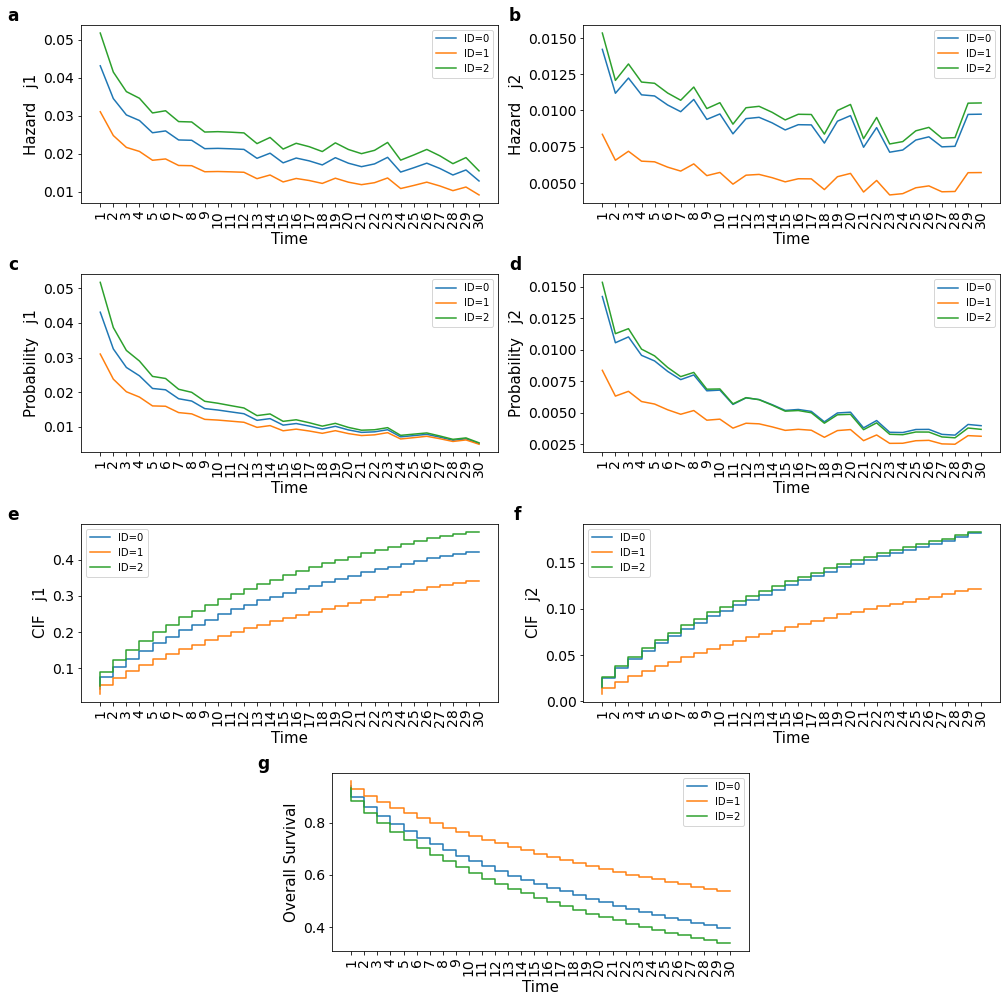

In [14]:
from pydts.examples_utils.plots import plot_example_pred_output
plot_example_pred_output(pred_df)

In [15]:
pred_df

,ID=0,ID=1,ID=2
,,,
Z1,0.548814,0.645894,0.791725
Z2,0.715189,0.437587,0.528895
Z3,0.602763,0.891773,0.568045
Z4,0.544883,0.963663,0.925597
Z5,0.423655,0.383442,0.071036
overall_survival_t1,0.942684,0.960628,0.932938
overall_survival_t2,0.899636,0.930545,0.883002
overall_survival_t3,0.861480,0.903726,0.839277
overall_survival_t4,0.827201,0.879254,0.800236


# Estimating with TwoStagesFitter

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pydts.examples_utils.generate_simulations_data import generate_quick_start_df
import warnings
pd.set_option("display.max_rows", 500)
warnings.filterwarnings('ignore')
%matplotlib inline

In [17]:
real_coef_dict = {
    "alpha": {
        1: lambda t: -1 - 0.3 * np.log(t),
        2: lambda t: -1.75 - 0.15 * np.log(t)
    },
    "beta": {
        1: -np.log([0.8, 3, 3, 2.5, 2]),
        2: -np.log([1, 3, 4, 3, 2])
    }
}

n_patients = 50000
n_cov = 5

In [18]:
patients_df = generate_quick_start_df(n_patients=n_patients, n_cov=n_cov, d_times=30, j_events=2, 
                                      pid_col='pid', seed=0, censoring_prob=0.8, 
                                      real_coef_dict=real_coef_dict)
patients_df.head()

,pid,Z1,Z2,Z3,Z4,Z5,J,T,C,X
0,0,0.548814,0.715189,0.602763,0.544883,0.423655,0,30,10,10
1,1,0.645894,0.437587,0.891773,0.963663,0.383442,0,30,24,24
2,2,0.791725,0.528895,0.568045,0.925597,0.071036,0,17,11,11
3,3,0.087129,0.020218,0.832620,0.778157,0.870012,1,1,30,1
4,4,0.978618,0.799159,0.461479,0.780529,0.118274,0,15,14,14


## Estimation

In the following we apply the estimation method of Meir et al. (2022). Note that the data dataframe must not contain a column named 'C'.

In [19]:
from pydts.fitters import TwoStagesFitter
new_fitter = TwoStagesFitter()
new_fitter.fit(df=patients_df.drop(['C', 'T'], axis=1))

new_fitter.print_summary()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


,j1_params,j1_SE,j2_params,j2_SE
covariate,,,,
Z1,0.187949,0.025068,0.040169,0.037807
Z2,-1.100792,0.025610,-1.100246,0.038696
Z3,-1.093466,0.025726,-1.410202,0.039280
Z4,-0.874521,0.025437,-1.097849,0.038642
Z5,-0.652655,0.025280,-0.654501,0.038179




Model summary for event: 1


n_jt  success  alpha_jt
J X                          
1 1   3374     True -0.987702
  2   2328     True -1.220809
  3   1805     True -1.358580
  4   1524     True -1.409997
  5   1214     True -1.530437
  6   1114     True -1.511889
  7    916     True -1.614043
  8    830     True -1.618019
  9    683     True -1.718359
  10   626     True -1.714668
  11   569     True -1.720344
  12   516     True -1.728207
  13   419     True -1.845399
  14   410     True -1.776981
  15   326     True -1.909345
  16   320     True -1.841848
  17   280     True -1.881339
  18   240     True -1.950204
  19   243     True -1.837087
  20   204     True -1.914093
  21   176     True -1.978425
  22   167     True -1.935467
  23   166     True -1.832599
  24   118     True -2.068397
  25   114     True -1.996911
  26   109     True -1.925090
  27    89     True -2.008449
  28    70     True -2.120056
  29    67     True -2.033129
  30    47     True -2.231271



Model summary for event: 2


n_jt  success  alpha_jt
J X                          
2 1   1250     True -1.737087
  2    839     True -1.981763
  3    805     True -1.881945
  4    644     True -1.991485
  5    570     True -1.998569
  6    483     True -2.055976
  7    416     True -2.099660
  8    409     True -2.019652
  9    323     True -2.150486
  10   306     True -2.112509
  11   240     True -2.250577
  12   246     True -2.142076
  13   226     True -2.132065
  14   198     True -2.168557
  15   170     True -2.215715
  16   162     True -2.178298
  17   147     True -2.178342
  18   115     True -2.346988
  19   125     True -2.151499
  20   118     True -2.113865
  21    83     True -2.380588
  22    89     True -2.190208
  23    65     True -2.421944
  24    59     True -2.401785
  25    58     True -2.318061
  26    53     True -2.291874
  27    43     True -2.373117
  28    38     True -2.368179
  29    43     True -2.115566
  30    37     True -2.113986

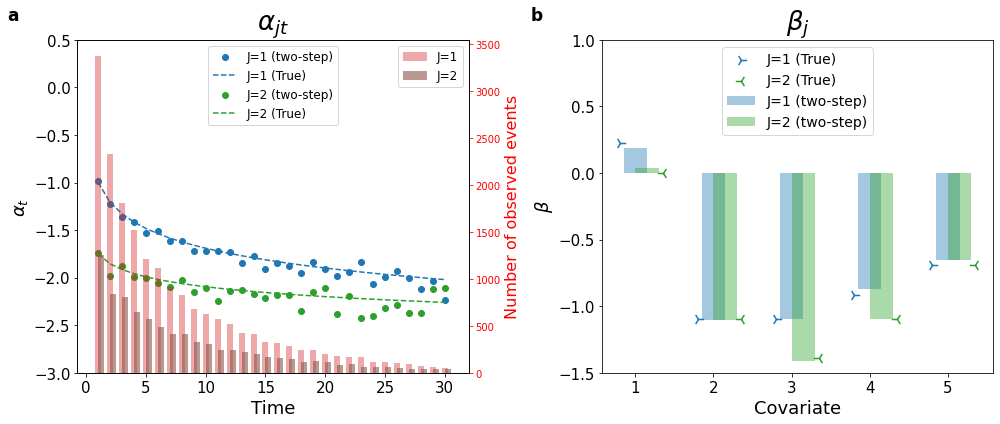

In [20]:
from pydts.examples_utils.plots import plot_second_model_coefs
plot_second_model_coefs(new_fitter.alpha_df, new_fitter.beta_models, new_fitter.times, n_cov=5)

## Standard Error of the Regression Coefficients

In [21]:
twostep_beta_summary = new_fitter.get_beta_SE()
twostep_beta1_summary = twostep_beta_summary.iloc[:,[0,1]]
twostep_beta2_summary = twostep_beta_summary.iloc[:,[2,3]]
twostep_beta_summary

,j1_params,j1_SE,j2_params,j2_SE
covariate,,,,
Z1,0.187949,0.025068,0.040169,0.037807
Z2,-1.100792,0.025610,-1.100246,0.038696
Z3,-1.093466,0.025726,-1.410202,0.039280
Z4,-0.874521,0.025437,-1.097849,0.038642
Z5,-0.652655,0.025280,-0.654501,0.038179


## Standard Error of the Regression Coefficients Comparison Table

In [22]:
lee_beta1_summary.round(3)

,coef,std err,z,P>|z|,[0.025,0.975]
,,,,,,
Z1,0.1930,0.026,7.495,0.000,0.143,0.244
Z2,-1.1306,0.026,-42.971,0.000,-1.182,-1.079
Z3,-1.1237,0.026,-42.515,0.000,-1.176,-1.072
Z4,-0.8986,0.026,-34.377,0.000,-0.950,-0.847
Z5,-0.6720,0.026,-25.869,0.000,-0.723,-0.621


In [23]:
lee_beta1_summary = lee_beta1_summary.iloc[:, [0,1]].round(3)
lee_beta2_summary = lee_beta2_summary.iloc[:, [0,1]].round(3)
lee_beta1_summary.columns = pd.MultiIndex.from_tuples([('Lee et al.', 'Estimate'), ('Lee et al.', 'SE')])
lee_beta2_summary.columns = pd.MultiIndex.from_tuples([('Lee et al.', 'Estimate'), ('Lee et al.', 'SE')])
beta_summary_comparison = pd.concat([lee_beta1_summary, lee_beta2_summary], axis=0)
beta_summary_comparison.index = [r'$\beta_{11}$', r'$\beta_{12}$', r'$\beta_{13}$', r'$\beta_{14}$', r'$\beta_{15}$',
                                 r'$\beta_{21}$', r'$\beta_{22}$', r'$\beta_{23}$', r'$\beta_{24}$', r'$\beta_{25}$']
twostep_beta1_summary.columns = pd.MultiIndex.from_tuples([('two-step', 'Estimate'), ('two-step', 'SE')])
twostep_beta2_summary.columns = pd.MultiIndex.from_tuples([('two-step', 'Estimate'), ('two-step', 'SE')])
tmp = pd.concat([twostep_beta1_summary.round(3), twostep_beta2_summary.round(3)], axis=0)
tmp.index = [r'$\beta_{11}$', r'$\beta_{12}$', r'$\beta_{13}$', r'$\beta_{14}$', r'$\beta_{15}$',
             r'$\beta_{21}$', r'$\beta_{22}$', r'$\beta_{23}$', r'$\beta_{24}$', r'$\beta_{25}$']
beta_summary_comparison = pd.concat([beta_summary_comparison, tmp], axis=1)
beta_summary_comparison.index.name =  r'$\beta_{jk}$'

true_col = -np.log([0.8, 3, 3, 2.5, 2, 1, 3, 4, 3, 2])   
beta_summary_comparison.insert(loc=0, column='True', value=true_col)
beta_summary_comparison.astype(float).round(3)

True Lee et al.        two-step       
                      Estimate     SE Estimate     SE
$\beta_{jk}$                                         
$\beta_{11}$  0.223      0.193  0.026    0.188  0.025
$\beta_{12}$ -1.099     -1.131  0.026   -1.101  0.026
$\beta_{13}$ -1.099     -1.124  0.026   -1.093  0.026
$\beta_{14}$ -0.916     -0.899  0.026   -0.875  0.025
$\beta_{15}$ -0.693     -0.672  0.026   -0.653  0.025
$\beta_{21}$ -0.000      0.041  0.038    0.040  0.038
$\beta_{22}$ -1.099     -1.113  0.039   -1.100  0.039
$\beta_{23}$ -1.386     -1.426  0.040   -1.410  0.039
$\beta_{24}$ -1.099     -1.111  0.039   -1.098  0.039
$\beta_{25}$ -0.693     -0.662  0.039   -0.655  0.038

In [24]:
print(beta_summary_comparison.astype(float).round(3).to_latex(escape=False))

\begin{tabular}{lrrrrr}
\toprule
{} &   True & \multicolumn{2}{l}{Lee et al.} & \multicolumn{2}{l}{two-step} \\
{} &   Estimate &     SE & Estimate &     SE \\
$\beta_{jk}$ &        &            &        &          &        \\
\midrule
$\beta_{11}$ &  0.223 &      0.193 &  0.026 &    0.188 &  0.025 \\
$\beta_{12}$ & -1.099 &     -1.131 &  0.026 &   -1.101 &  0.026 \\
$\beta_{13}$ & -1.099 &     -1.124 &  0.026 &   -1.093 &  0.026 \\
$\beta_{14}$ & -0.916 &     -0.899 &  0.026 &   -0.875 &  0.025 \\
$\beta_{15}$ & -0.693 &     -0.672 &  0.026 &   -0.653 &  0.025 \\
$\beta_{21}$ & -0.000 &      0.041 &  0.038 &    0.040 &  0.038 \\
$\beta_{22}$ & -1.099 &     -1.113 &  0.039 &   -1.100 &  0.039 \\
$\beta_{23}$ & -1.386 &     -1.426 &  0.040 &   -1.410 &  0.039 \\
$\beta_{24}$ & -1.099 &     -1.111 &  0.039 &   -1.098 &  0.039 \\
$\beta_{25}$ & -0.693 &     -0.662 &  0.039 &   -0.655 &  0.038 \\
\bottomrule
\end{tabular}



## Regularization

It is possible to add regularization when estimating the Beta coefficients. It is done by using the CoxPHFitter (Lifelines) penalizer and l1_ratio arguments, which can be passed using the fit_beta_kwargs argument to the fit() method. The added regularization term is of the form:
$$
\mbox{Penalizer} \cdot \Bigg( \frac{1-\mbox{L1_ratio}}{2}||\beta||_{2}^{2} + \mbox{L1_ratio} ||\beta||_1 \Bigg)
$$
Examples for adding L1, L2 and Elastic Net regularization are followed.

### L1

In [25]:
L1_regularized_fitter = TwoStagesFitter()

fit_beta_kwargs = {
    'model_kwargs': {
        'penalizer': 0.003,
        'l1_ratio': 1
    }
}

L1_regularized_fitter.fit(df=patients_df.drop(['C', 'T'], axis=1), fit_beta_kwargs=fit_beta_kwargs)

L1_regularized_fitter.get_beta_SE()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


,j1_params,j1_SE,j2_params,j2_SE
covariate,,,,
Z1,0.000002,0.000102,5.690226e-08,0.000041
Z2,-0.774487,0.025401,-3.574822e-01,0.038251
Z3,-0.762942,0.025533,-6.516077e-01,0.038510
Z4,-0.552172,0.025318,-3.590965e-01,0.038235
Z5,-0.340120,0.025211,-1.435430e-06,0.000132


### L2

In [26]:
L2_regularized_fitter = TwoStagesFitter()

fit_beta_kwargs = {
    'model_kwargs': {
        'penalizer': 0.003,
        'l1_ratio': 0
    }
}

L2_regularized_fitter.fit(df=patients_df.drop(['C', 'T'], axis=1), fit_beta_kwargs=fit_beta_kwargs)

L2_regularized_fitter.get_beta_SE()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


,j1_params,j1_SE,j2_params,j2_SE
covariate,,,,
Z1,0.172957,0.024069,0.032774,0.034626
Z2,-1.007262,0.024506,-0.903957,0.035205
Z3,-1.000509,0.024629,-1.162132,0.035589
Z4,-0.799488,0.024384,-0.903531,0.035177
Z5,-0.597079,0.024255,-0.537159,0.034911


### Elastic Net

In [27]:
EN_regularized_fitter = TwoStagesFitter()

fit_beta_kwargs = {
    'model_kwargs': {
        'penalizer': 0.003,
        'l1_ratio': 0.5
    }
}

EN_regularized_fitter.fit(df=patients_df.drop(['C', 'T'], axis=1), fit_beta_kwargs=fit_beta_kwargs)

EN_regularized_fitter.get_beta_SE()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


,j1_params,j1_SE,j2_params,j2_SE
covariate,,,,
Z1,0.039322,0.024542,0.000001,0.000190
Z2,-0.895581,0.024938,-0.654614,0.036595
Z3,-0.886332,0.025065,-0.928867,0.036941
Z4,-0.680998,0.024832,-0.655263,0.036573
Z5,-0.473818,0.024711,-0.265356,0.036382


### Separated Penalty Coefficients

The above methods can be applied with a separate penalty coefficient to each of the covariates by passing a vector (with same length as the number of covariates) to the penalizer keyword instead of a scalar. For example, applying L2 regularization only to covariates Z1, Z2 can be done as follows:

In [28]:
L2_regularized_fitter = TwoStagesFitter()

fit_beta_kwargs = {
    'model_kwargs': {
        'penalizer': np.array([0.04, 0.04, 0, 0, 0]),
        'l1_ratio': 0
    }
}

L2_regularized_fitter.fit(df=patients_df.drop(['C', 'T'], axis=1), fit_beta_kwargs=fit_beta_kwargs)

L2_regularized_fitter.get_beta_SE()

INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


,j1_params,j1_SE,j2_params,j2_SE
covariate,,,,
Z1,0.088314,0.017178,0.011120,0.020019
Z2,-0.515292,0.017378,-0.306194,0.020269
Z3,-1.069182,0.025695,-1.374391,0.039205
Z4,-0.853807,0.025419,-1.066715,0.038602
Z5,-0.641989,0.025272,-0.637811,0.038161


## Prediction

Full prediction is given by the method predict_cumulative_incident_function()

The input is a pandas.DataFrame() containing for each observation the covariates columns which were used in the fit() method (Z1-Z5 in our example).

The following columns will be added:

1. The overall survival at each time point t
2. The hazard for each failure type $j$ at each time point t
3. The probability of event type $j$ at time t
4. The Cumulative Incident Function (CIF) of event type $j$ at time t

In the following, we provide predictions for the individuals with ID values (pid) 0, 1 and 2. We transposed the output for easy view.

In [29]:
pred_df = new_fitter.predict_cumulative_incident_function(
    patients_df.drop(['J', 'T', 'C', 'X'], axis=1).head(3)).set_index('pid').T
pred_df.index.name = ''
pred_df.columns = ['ID=0', 'ID=1', 'ID=2']

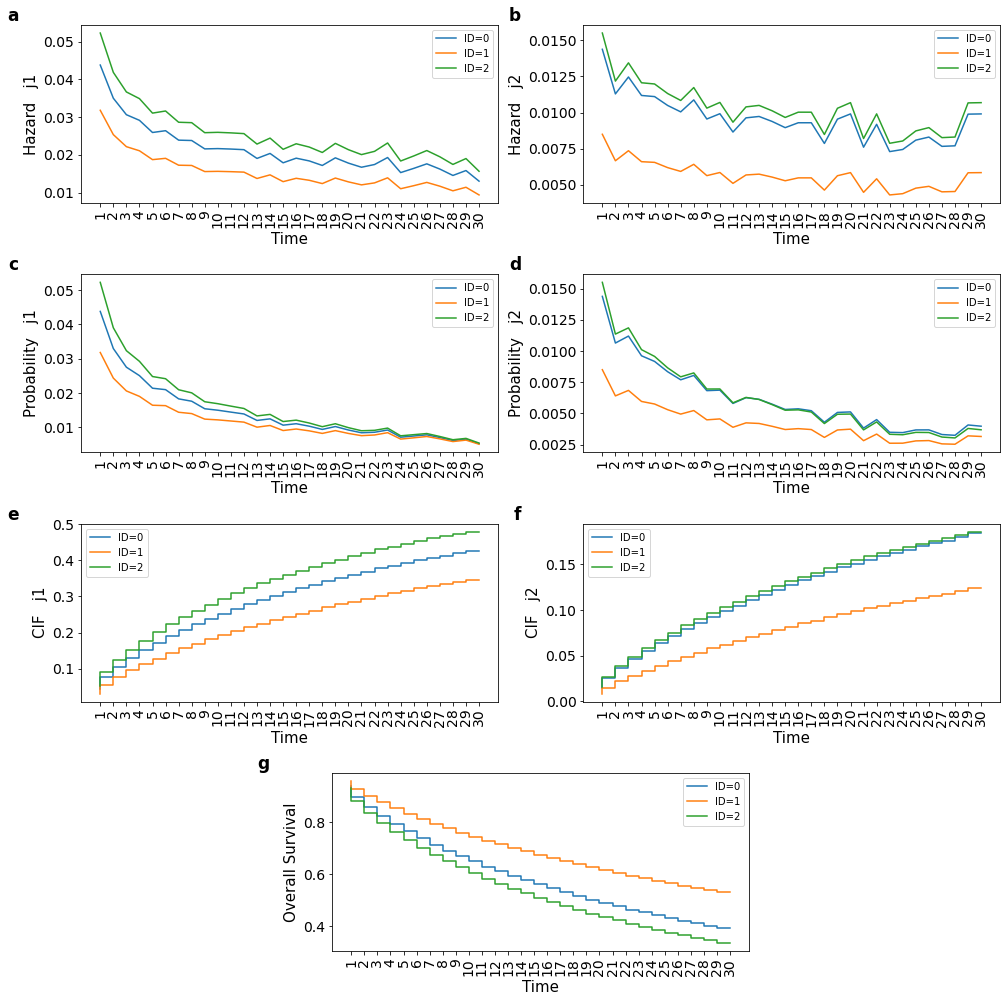

In [30]:
from pydts.examples_utils.plots import plot_example_pred_output
plot_example_pred_output(pred_df)

In [31]:
pred_df

,ID=0,ID=1,ID=2
,,,
Z1,0.548814,0.645894,0.791725
Z2,0.715189,0.437587,0.528895
Z3,0.602763,0.891773,0.568045
Z4,0.544883,0.963663,0.925597
Z5,0.423655,0.383442,0.071036
overall_survival_t1,0.941845,0.959704,0.932244
overall_survival_t2,0.898252,0.928975,0.881883
overall_survival_t3,0.859546,0.901548,0.837705
overall_survival_t4,0.824888,0.876595,0.798379


# Comparing the Estimation Methods

## Introduction

We conducted a simulation study demonstrating the performances of Meir et al. (2022) [1] and comparing it with that of Lee et al. (2018) [2]. 

The data was generated in the same way as in Usage Example section, i.e. $M=2$ competing events, $n=50,000$ observations, Z with 5 covariates and right censoring. 

Failure times were generated based on 

$$
\lambda_{j}(t|Z) = \frac{\exp(\alpha_{jt}+Z^{T}\beta_{j})}{1+\exp(\alpha_{jt}+Z^{T}\beta_{j})}
$$

with 

$\alpha_{1t} = -1 -0.3 \log(t)$, 

$\alpha_{2t} = -1.75 -0.15\log(t)$, $t=1,\ldots,d$,

$\beta_1 = (-\log 0.8, \log 3, \log 3, \log 2.5, \log 2)$, 

$\beta_{2} = (-\log 1, \log 3, \log 4, \log 3, \log 2)$. 

Censoring time for each observation was sampled from a discrete uniform distribution, i.e. $C_i \sim \mbox{Uniform}\{1,...,d+1\}$. 

We repeated this procedure for $d \in (15, 30, 45, 60, 100)$ and report the results in Meir et al. (2022) [1]. For each value of $d$, the results are based on 100 replications. 

We showed that both estimation methods perform very well in terms of bias and provide highly similar results in terms of point estimators and their standard errors. However, the computational running time of our approach is 1.5-3.5 times shorter depending on $d$, where the improvement factor increases as a function of $d$.

## Estimation Replications

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pydts.examples_utils.generate_simulations_data import generate_quick_start_df
import warnings
pd.set_option("display.max_rows", 500)
warnings.filterwarnings('ignore')
%matplotlib inline

In [33]:
real_coef_dict = {
    "alpha": {
        1: lambda t: -1 - 0.3 * np.log(t),
        2: lambda t: -1.75 - 0.15 * np.log(t)
    },
    "beta": {
        1: -np.log([0.8, 3, 3, 2.5, 2]),
        2: -np.log([1, 3, 4, 3, 2])
    }
}

n_patients = 50000
n_cov = 5


# In JSS paper the results of 100 replications are presented.
# We present the results here for 5 replication for reasonable running time.
# For higher number of d_times, longer running time is expected.
# Estimated running time for each replication when d=30: 45 seconds

replications = 5  
d_times = 30 

In [34]:
from pydts.fitters import repetitive_fitters
rep_dict, times_dict, counts_df = repetitive_fitters(rep=replications, n_patients=n_patients, n_cov=n_cov, 
                                                     d_times=30, j_events=2, pid_col='pid', test_size=0.25, 
                                                     verbose=0, real_coef_dict=real_coef_dict, censoring_prob=0.8,
                                                     allow_fails=2)

 57%|█████████████████████████▋                   | 4/7 [03:44<02:48, 56.23s/it]

final: 5


## Comparing Standard Error of Lee et al. (2018) and Meir et al. (2022)

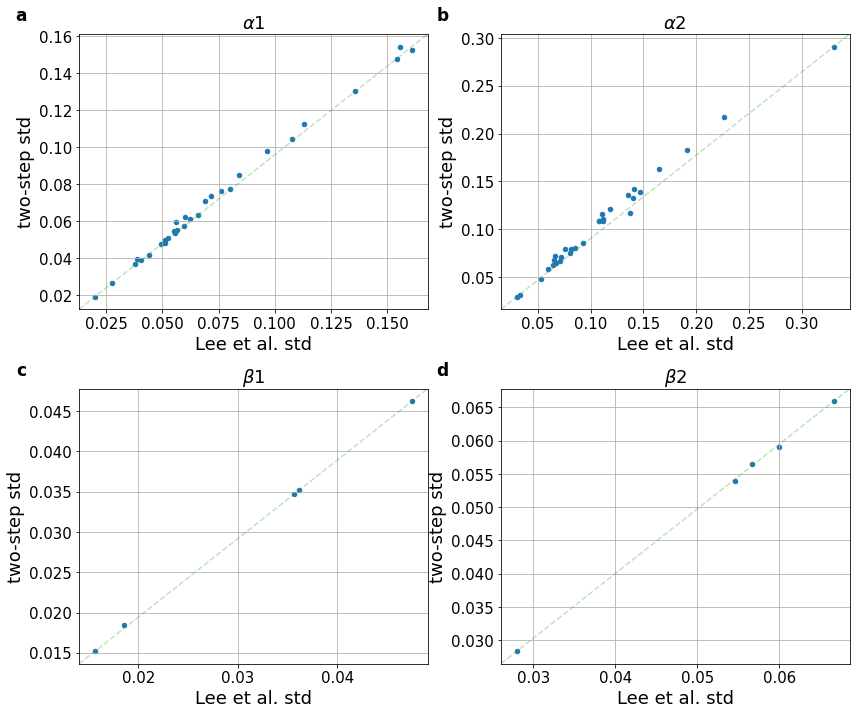

In [35]:
from pydts.examples_utils.plots import plot_reps_coef_std

new_res_dict = plot_reps_coef_std(rep_dict, True)

## Comparison of the Estimated Coefficients

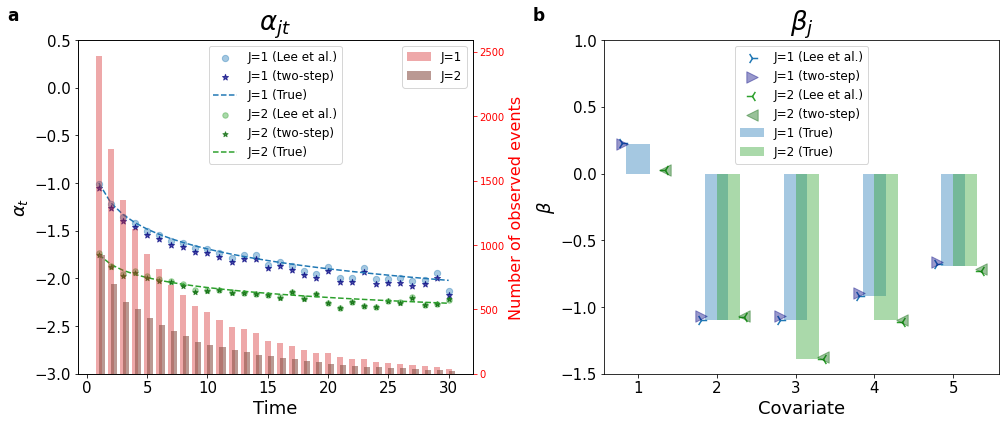

In [36]:
from pydts.examples_utils.plots import plot_models_coefficients
a = new_res_dict['alpha']
b = new_res_dict['beta']
times = [t+1 for t in list(a[1].reset_index().index)]
n_cov = 5
plot_models_coefficients(a, b, times, counts_df)

## Computational Time Comparison

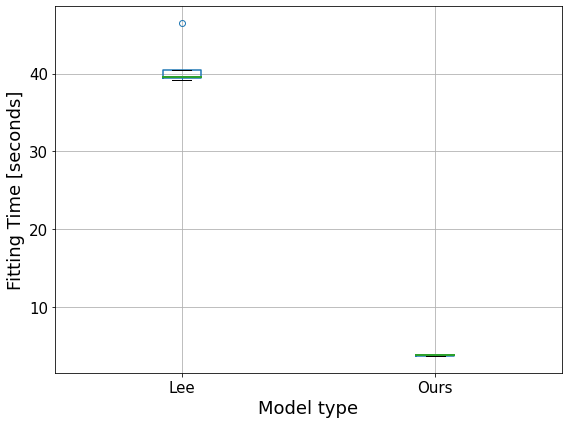

<AxesSubplot:xlabel='Model type', ylabel='Fitting Time [seconds]'>

In [37]:
from pydts.examples_utils.plots import plot_times

plot_times(times_dict)

In [38]:
beta_comparison_table = pd.DataFrame(index=['True', 'Mean (Lee et al.)', 'SE (Lee et al.)',
                                              'Mean (two-step)', 'SE (two-step)'])
for j in [1, 2]:
    for i in range(1, 6):
        tmp_df = pd.DataFrame()
        for idx, k in enumerate(sorted(rep_dict.keys())):
            lee = rep_dict[k]['beta'][j].loc[f"Z{i}_{j}"]['Lee']
            ours = rep_dict[k]['beta'][j].loc[f"Z{i}_{j}"]['Ours']
            true = rep_dict[k]['beta'][j].loc[f"Z{i}_{j}"]['real']
            row = pd.Series({'True': true, 'Lee': lee, 'Ours': ours}, name=f"Z{i}_{j}_{k}")
            tmp_df = pd.concat([tmp_df, row], axis=1)
        beta_row = pd.Series({
            'True': tmp_df.iloc[0,0],
            'Mean (Lee et al.)': tmp_df.iloc[1].mean(), 
            'SE (Lee et al.)': tmp_df.iloc[1].std(),
            'Mean (two-step)': tmp_df.iloc[2].mean(),
            'SE (two-step)': tmp_df.iloc[2].std()
        }, name=f'Z{i}_{j}')
        beta_comparison_table = pd.concat([beta_comparison_table, beta_row], axis=1)


In [39]:
beta_comparison_table = beta_comparison_table.round(3).T
beta_comparison_table.columns = pd.MultiIndex.from_tuples(
    [('True', ''), ('Lee et al.', 'Estimate'), ('Lee et al.', 'SE'), ('two-step', 'Estimate'), ('two-step', 'SE')])
beta_comparison_table.index = [r'$\beta_{11}$', r'$\beta_{12}$', r'$\beta_{13}$', r'$\beta_{14}$', r'$\beta_{15}$',
                               r'$\beta_{21}$', r'$\beta_{22}$', r'$\beta_{23}$', r'$\beta_{24}$', r'$\beta_{25}$']
beta_comparison_table.index.name = r'$\beta_{jk}$'
beta_comparison_table

True Lee et al.        two-step       
                      Estimate     SE Estimate     SE
$\beta_{jk}$                                         
$\beta_{11}$  0.223      0.227  0.036    0.221  0.035
$\beta_{12}$ -1.099     -1.098  0.036   -1.069  0.035
$\beta_{13}$ -1.099     -1.093  0.016   -1.065  0.015
$\beta_{14}$ -0.916     -0.919  0.019   -0.895  0.018
$\beta_{15}$ -0.693     -0.679  0.048   -0.661  0.046
$\beta_{21}$ -0.000      0.030  0.067    0.029  0.066
$\beta_{22}$ -1.099     -1.077  0.055   -1.065  0.054
$\beta_{23}$ -1.386     -1.391  0.028   -1.376  0.028
$\beta_{24}$ -1.099     -1.111  0.060   -1.098  0.059
$\beta_{25}$ -0.693     -0.727  0.057   -0.718  0.056

In [40]:
print(beta_comparison_table.to_latex(escape=False))

\begin{tabular}{lrrrrr}
\toprule
{} &   True & \multicolumn{2}{l}{Lee et al.} & \multicolumn{2}{l}{two-step} \\
{} &   Estimate &     SE & Estimate &     SE \\
$\beta_{jk}$ &        &            &        &          &        \\
\midrule
$\beta_{11}$ &  0.223 &      0.227 &  0.036 &    0.221 &  0.035 \\
$\beta_{12}$ & -1.099 &     -1.098 &  0.036 &   -1.069 &  0.035 \\
$\beta_{13}$ & -1.099 &     -1.093 &  0.016 &   -1.065 &  0.015 \\
$\beta_{14}$ & -0.916 &     -0.919 &  0.019 &   -0.895 &  0.018 \\
$\beta_{15}$ & -0.693 &     -0.679 &  0.048 &   -0.661 &  0.046 \\
$\beta_{21}$ & -0.000 &      0.030 &  0.067 &    0.029 &  0.066 \\
$\beta_{22}$ & -1.099 &     -1.077 &  0.055 &   -1.065 &  0.054 \\
$\beta_{23}$ & -1.386 &     -1.391 &  0.028 &   -1.376 &  0.028 \\
$\beta_{24}$ & -1.099 &     -1.111 &  0.060 &   -1.098 &  0.059 \\
$\beta_{25}$ & -0.693 &     -0.727 &  0.057 &   -0.718 &  0.056 \\
\bottomrule
\end{tabular}



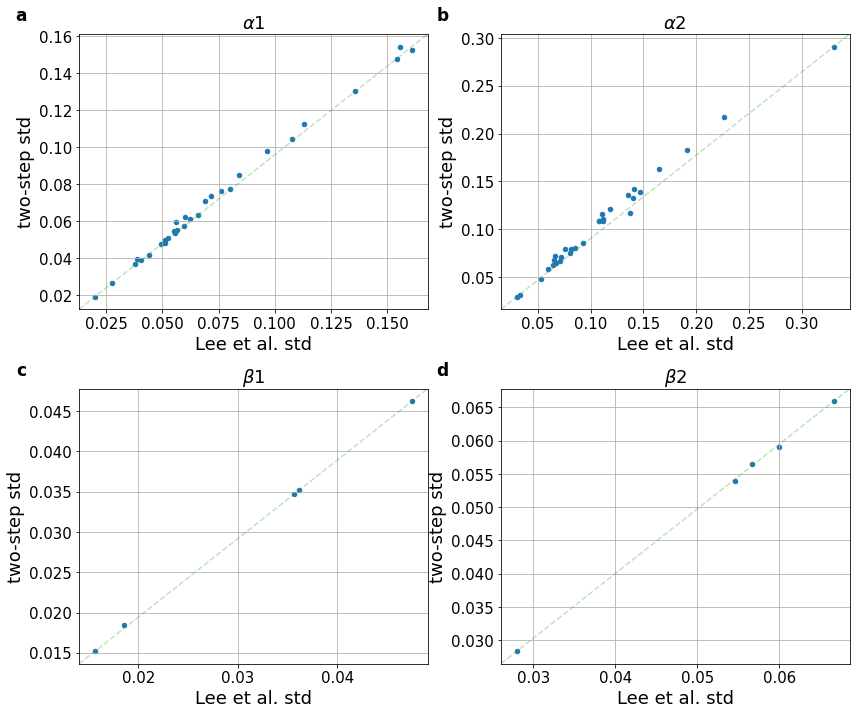

In [41]:
from pydts.examples_utils.plots import plot_reps_coef_std

new_res_dict = plot_reps_coef_std(rep_dict)

## References

[1] Meir, Tomer\*, Gutman, Rom\*, and Gorfine, Malka, "PyDTS: A Python Package for Discrete-Time Survival Analysis with Competing Risks" (2022)

[2] Lee, Minjung and Feuer, Eric J. and Fine, Jason P., "On the analysis of discrete time competing risks data", Biometrics (2018) doi: 10.1111/biom.12881